<a href="https://colab.research.google.com/github/dominiquebuford/AIPI540-project1/blob/dombuford/resNetNaive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import necessary dependencies
import os
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [2]:
def open_kaggle_dataset():
  # set up access to Kaggle API
  !pip install -q kaggle
  from google.colab import files
  files.upload()
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle datasets download -d misrakahmed/vegetable-image-dataset
  !unzip vegetable-image-dataset.zip -d .

In [3]:
def transform_grab_data():
  #perform transformations to the images and normalize to mean and std of resnet18
  transformations = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])
  #use Pythorch ImageFolder() function to create validation dataset
  validation_images_dir = './Vegetable Images/validation'
  val_ds = ImageFolder(validation_images_dir, transform = transformations)

  return val_ds


In [4]:
def get_model():
  #use resnet18 pretrained then change FC for 15 classes
    model = models.resnet18(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 15),
    nn.Softmax(dim=1))

    return model.to(device)

In [5]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    logits = model(x.cuda())
    pred = logits.argmax(1).flatten().cpu() #to get a single prediction from the 15 classes
    is_correct = (pred) == y
    return is_correct.numpy().tolist()


In [6]:
def get_data(val_ds):
    #convert dataset to dataloader for model evaluation
    return DataLoader(val_ds, batch_size=32, shuffle=True, drop_last = True)

In [7]:
def run_validation(val_dl, model):
  val_accuracies = []
  for epoch in range(10):
      print(f" epoch {epoch + 1}/10")
      val_epoch_accuracies = []
      for ix, batch in enumerate(iter(val_dl)):
          x, y = batch
          val_is_correct = accuracy(x, y, model)
          val_epoch_accuracies.extend(val_is_correct)
      val_epoch_accuracy = np.mean(val_epoch_accuracies)

      val_accuracies.append(val_epoch_accuracy)
  return val_accuracies

In [14]:
def visualize_prediction(path, model):
  #take image at path and give prediction from model and display image
  im = cv2.imread(path)
  im = cv2.resize(im, (224, 224))
  im = torch.tensor(im).permute(2, 0, 1)
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  im = normalize(im/255)
  im = im.unsqueeze(0)
  im = im.to(device)
  food_prediction = model(im)
  im=im.cpu().numpy()
  im = torch.from_numpy(im)
  im= im.squeeze(0)
  im = im.permute(1, 2, 0)
  predicted_class = torch.argmax(food_prediction)
  print(val_ds.classes[predicted_class])
  plt.imshow(im)



Saving kaggle.json to kaggle (1).json
kaggle.json
vegetable-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  vegetable-image-dataset.zip
replace ./Vegetable Images/test/Bean/0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 epoch 1/10
 epoch 2/10
 epoch 3/10
 epoch 4/10
 epoch 5/10
 epoch 6/10
 epoch 7/10
 epoch 8/10
 epoch 9/10
 epoch 10/10


Bean
[0.07426075268817205, 0.07829301075268817, 0.06686827956989247, 0.07325268817204302, 0.07190860215053764, 0.06854838709677419, 0.06821236559139784, 0.07056451612903226, 0.07123655913978495, 0.08098118279569892]


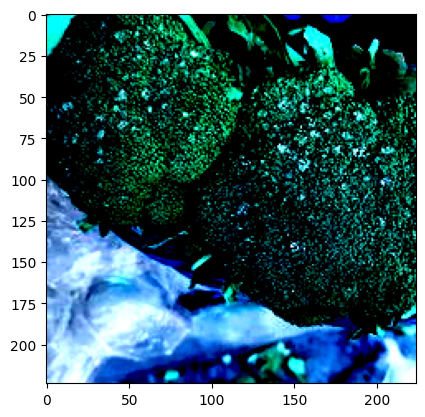

In [10]:
open_kaggle_dataset()
val_ds = transform_grab_data()
val_dl = get_data(val_ds)
model = get_model()
val_accuracies = run_validation(val_dl, model)
visualize_prediction('/content/Vegetable Images/validation/Broccoli/1201.jpg', model)
print(val_accuracies)